In [14]:
from env import get_db_url
import numpy as np
import pandas as pd
import os
import acquire
import prepare
import wrangle
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import explore
import pydataset
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [15]:
zillow_predictions = wrangle.wrangle_zillow_predictions()
zillow_predictions.isna().sum()
zillow_predictions

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,0,1,0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,0,0,1
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,0,1,0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,1,0,0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,1,0,0
...,...,...,...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0,1962.0,4175.08,1,0,0
52437,2.0,2.0,1286.0,354621.0,1940.0,4478.43,1,0,0
52438,4.0,2.0,1612.0,67205.0,1964.0,1107.48,0,0,1
52439,3.0,1.0,1032.0,49546.0,1954.0,876.43,1,0,0


In [16]:
train, validate, test = wrangle.split_data(zillow_predictions)
train

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1959.0,4968.19,1,0,0
38332,2.0,1.0,1638.0,126907.0,1927.0,1500.66,1,0,0
32297,4.0,2.0,1725.0,592000.0,1966.0,7380.59,1,0,0
31139,2.0,1.0,1015.0,172499.0,1925.0,2252.18,1,0,0
20188,1.0,1.0,565.0,292368.0,1915.0,3624.67,1,0,0
...,...,...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,1959.0,6464.74,0,0,1
8268,3.0,2.0,1534.0,380623.0,1970.0,4731.33,1,0,0
2175,2.0,1.5,1213.0,431697.0,1956.0,5451.26,0,1,0
11049,3.0,2.0,1584.0,271747.0,1959.0,3386.08,1,0,0


In [17]:
#explore.plot_variable_pairs(train)

### These graphs are from zillow_predictions without dummy variables for fips

In [18]:
#explore.plot_categorical_and_continuous_vars(zillow_predictions, discrete_list, continuous_list, sample_size=10000)

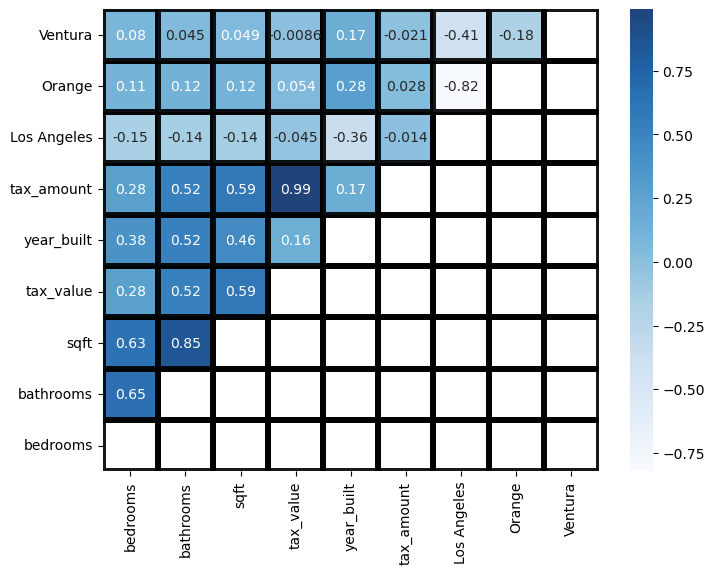

In [19]:
explore.correlation_heatmap(train)

Bathrooms are highly correlated with square feet so for linear regression I will take one out.  Judging by the heat map sqft is better correlated with our target of tax value so that is the one I will keep it over bathrooms and bedrooms in our past MVP.  Year built is also correlated with sqft so i might have another thing to say.  Maybe choose bedrooms and year built.

In [20]:
X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, X_test_mvp, y_test_mvp = explore.mvp_split(train, validate, test)

print(explore.select_kbest(X_train_mvp, y_train_mvp, n=3))
print(explore.rfe(X_train_mvp, y_train_mvp, n=3))

3 selected features
['bedrooms', 'bathrooms', 'sqft']
None
3 selected features
['Los Angeles', 'Orange', 'Ventura']
None


In [21]:
X_train_mvp

,bedrooms,bathrooms,sqft,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,1,0,0
38332,2.0,1.0,1638.0,1,0,0
32297,4.0,2.0,1725.0,1,0,0
31139,2.0,1.0,1015.0,1,0,0
20188,1.0,1.0,565.0,1,0,0
...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,0,0,1
8268,3.0,2.0,1534.0,1,0,0
2175,2.0,1.5,1213.0,0,1,0
11049,3.0,2.0,1584.0,1,0,0


### This lends further creedence to the guess that these three columns should be combined into one in later linear Regression

In [22]:
y_train_mvp, y_validate_mvp, y_test_mvp, rmse_train_mvp_mean, rmse_validate_mvp_mean = explore.baseline_rmse(y_train_mvp, y_validate_mvp, y_test_mvp)

RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99


In [27]:
#. Create the model object
lm_mvp = LinearRegression()

#. Fit to training and specify column in y_train since it is now a series
lm_mvp.fit(X_train_mvp, y_train_mvp.tax_value)

# predict
y_train_mvp['tax_value_pred_lm'] = lm_mvp.predict(X_train_mvp)

# RMSE
rmse_train_mvp_lm = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate_mvp['tax_value_pred_lm'] = lm_mvp.predict(X_validate_mvp)

#Validate RMSE 
rmse_validate_mvp_lm = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_lm) ** (1/2)

print('RMSE for OLS using LinearRegression\nTraining/In-Sample: ', rmse_train_mvp_lm,
     '\nValidation/Out-of-Sample: ', rmse_validate_mvp_lm)


RMSE for OLS using LinearRegression
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010334001


In [30]:
dd

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,771278.989474,754399.985039,0.000000
1,Linear Regression,612017.820343,582749.801033,0.227532


In [31]:

lars_mvp = LassoLars(alpha=10)

#. Fit to training and specify column in y_train since it is now a series
lars_mvp.fit(X_train_mvp, y_train_mvp.tax_value)

# predict
y_train_mvp['tax_value_pred_lars'] = lars_mvp.predict(X_train_mvp)

# RMSE
rmse_train_mvp_lars = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate_mvp['tax_value_pred_lars'] = lars_mvp.predict(X_validate_mvp)

#Validate RMSE 
rmse_validate_mvp_lars = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_lars) ** (1/2)

print('RMSE  using LassoLars\nTraining/In-Sample: ', rmse_train_mvp_lars,
     '\nValidation/Out-of-Sample: ', rmse_validate_mvp_lars,
     '\With alpha= 10')

RMSE  using LassoLars
Training/In-Sample:  612017.8219824053 
Validation/Out-of-Sample:  582749.4938726074 \With alpha= 10


,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,771278.989474,754399.985039,0.000000
1,Linear Regression,612017.820343,582749.801033,0.227532
2,LassoLars alpha=10,612017.821982,582749.493873,0.227532


In [33]:
# make the polynomial features to get a new set of features
pf_mvp = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_mvp = pf_mvp.fit_transform(X_train_mvp)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_mvp = pf_mvp.transform(X_validate_mvp)
X_test_degree2_mvp = pf_mvp.transform(X_test_mvp)

# create the model object
lm2_mvp = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2_mvp.fit(X_train_degree2_mvp, y_train_mvp.tax_value)

# predict train
y_train_mvp['tax_value_pred_poly'] = lm2_mvp.predict(X_train_degree2_mvp)

# evaluate: rmse
rmse_train_mvp_quad = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_poly)**(1/2)

# predict validate
y_validate_mvp['tax_value_pred_poly'] = lm2_mvp.predict(X_validate_degree2_mvp)

# evaluate: rmse
rmse_validate_mvp_quad = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_poly)**(1/2)

print("RMSE for Polynomial Model, degrees=", 2, "\nTraining/In-Sample: ", rmse_train_mvp_quad, 
      "\nValidation/Out-of-Sample: ", rmse_validate_mvp_quad)

RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  552256.3705779964 
Validation/Out-of-Sample:  562682.7144393248


In [34]:
# Let's house our metrics in a df to later compare
metric_df = pd.DataFrame(data = [
        {
            "model": "mean_baseline",
            "RMSE_train": rmse_train_mvp_mean,
            "RMSE_validate":rmse_validate_mvp_mean,
            "R2_validate": 0
        },
        {
            "model": "Linear Regression",
            "RMSE_train": rmse_train_mvp_lm,
            "RMSE_validate":rmse_validate_mvp_lm,
            "R2_validate": (rmse_validate_mvp_mean - rmse_validate_mvp_lm) / rmse_validate_mvp_mean
        },
        {
            "model": "LassoLars alpha=10",
            "RMSE_train": rmse_train_mvp_lars,
            "RMSE_validate":rmse_validate_mvp_lars,
            "R2_validate": (rmse_validate_mvp_mean - rmse_validate_mvp_lars) / rmse_validate_mvp_mean
        },
        {
            "model": "Quadratic Regression",
            "RMSE_train": rmse_train_mvp_quad,
            "RMSE_validate":rmse_validate_mvp_quad,
            "R2_validate": (rmse_validate_mvp_mean - rmse_validate_mvp_quad) / rmse_validate_mvp_mean
        }
])

metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,771278.989474,754399.985039,0.000000
1,Linear Regression,612017.820343,582749.801033,0.227532
2,LassoLars alpha=10,612017.821982,582749.493873,0.227532
3,Quadratic Regression,552256.370578,562682.714439,0.254132
